In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels

In [2]:
from all_models import *

In [3]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
#fits_eight = pickle.load(open('fit_dual_eight_CV_704.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))
fits_alpha = pickle.load(open('fit_dual_2alpha_CV_704.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [36]:
all_A = np.zeros(60*100)
all_B = np.zeros(60*100)
all_Af = np.zeros(60*100)
all_Bf = np.zeros(60*100)
all_As = np.zeros(60*100)
all_Bs = np.zeros(60*100)
all_alphas = np.zeros(60*100)
for i in range(100):
    all_A[i*60:(i+1)*60] = fits_single[i][:, 0]
    all_B[i*60:(i+1)*60] = fits_single[i][:, 1]
    all_Af[i*60:(i+1)*60] = fits_dual[i][:, 0]
    all_Bf[i*60:(i+1)*60] = fits_dual[i][:, 1]
    all_As[i*60:(i+1)*60] = fits_dual[i][:, 2]
    all_Bs[i*60:(i+1)*60] = fits_dual[i][:, 3]
    all_alphas[i*60:(i+1)*60] = fits_alpha[i][:, 4]

In [37]:
parameters_df = pd.DataFrame({'Participant_Id': np.tile(range(60), 100),
                         'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 15*100), 
                         'Emphasis': np.tile(['Speed', 'Accuracy'], 30*100),
                         'A': all_A,
                         'B': all_B,
                         'Af': all_Af,
                         'Bf': all_Bf,
                         'As': all_As,
                         'Bs': all_Bs,
                         'Alpha': all_alphas
                        })


In [137]:
parameters_means = parameters_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()
parameters_means['ratio'] = (parameters_means['Bs'])/(parameters_means['Bf'] + parameters_means['Bs'])

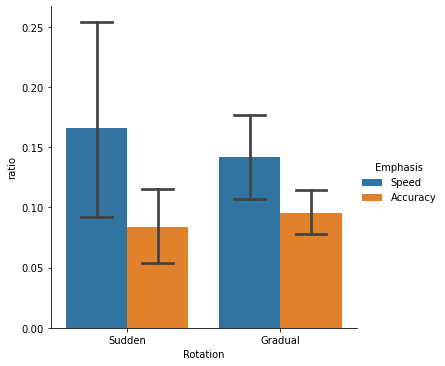

In [138]:
sns.catplot(x = 'Rotation', y = 'ratio', hue = 'Emphasis', data = parameters_means, kind = 'bar', capsize = 0.2)

In [133]:
model = smf.ols('ratio~Rotation*Emphasis', data = parameters_means).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.000133,0.000133,0.018315,0.892833
Emphasis,1.0,0.052526,0.052526,7.238307,0.009388
Rotation:Emphasis,1.0,0.020757,0.020757,2.860422,0.096342
Residual,56.0,0.406370,0.007257,NaN,NaN


In [94]:
alpha_medians = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).median().reset_index()
alpha_means = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()


Text(0.5, 0.8793567452082017, '*')

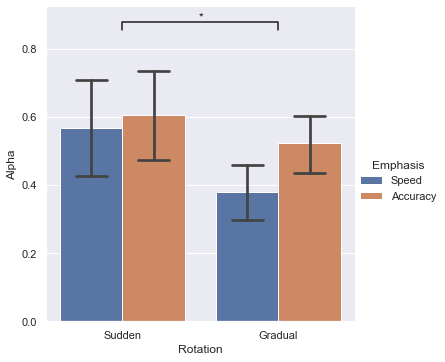

In [95]:
x1, x2 = 0, 1
y, h, col = alpha_means['Alpha'].max() - 0.2, 0.025, 'k'

sns.catplot(x = 'Rotation', y = 'Alpha', hue = 'Emphasis', data = alpha_means, kind = 'bar', capsize = 0.2)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


In [134]:
parameters_means['Errors'] = np.mean(curvatures_smooth[:, -1, :], axis = 1)

Text(0.5, 1.0, 'AfterEffects')

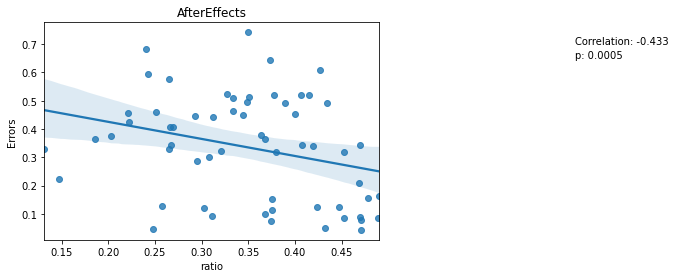

In [135]:
sns.regplot(y = 'Errors', x = 'ratio', data = parameters_means)
plt.text(0.7, 0.7, 'Correlation: -0.433')
plt.text(0.7, 0.65, 'p: 0.0005')
plt.title('AfterEffects')

In [136]:
stat.pearsonr(parameters_means['ratio'], parameters_means['Errors'])

(-0.29441057742699617, 0.02240762045351442)

In [10]:
conc = pd.read_csv('conc.csv')

In [11]:
parameters_means['Model_Selected'] = 'Dual_Selected'

In [12]:
parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'

<ipython-input-12-d289fa70e1c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'


In [13]:
parameters_means['Dual_Selected'] = 1
parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0

<ipython-input-13-0fc71f62f964>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0


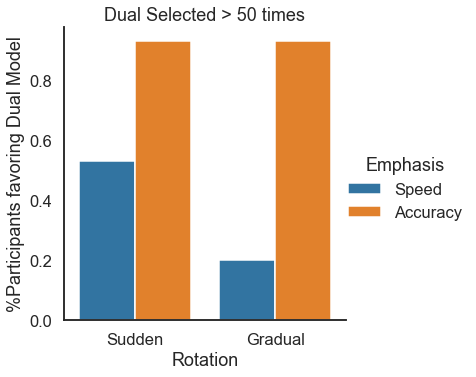

In [14]:
sns.set_context('talk')
sns.set_style('white')
cp = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'Dual_Selected', hue = 'Emphasis', kind = 'bar', ci = None)
plt.title('Dual Selected > 50 times')
cp.set_ylabels('%Participants favoring Dual Model')

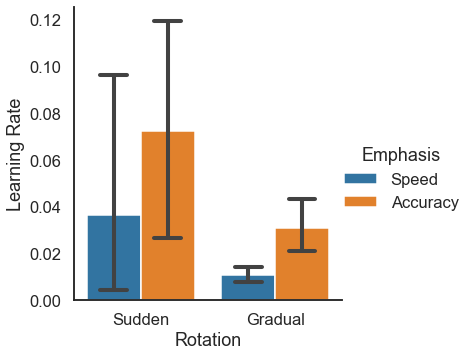

In [9]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2)
c.set(ylabel = 'Learning Rate')
#plt.title('Best fit by Single state')
#sns.boxplot(data = parameters_means,
#           x = 'Model_Selected', y = 'B', 
#            hue = 'Emphasis')
#plt.ylim((-0.2, 0.5))

In [65]:
model = smf.ols('B~Rotation*Model_Selected', data = parameters_means).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.016925,0.016925,3.027798,0.087342
Model_Selected,1.0,0.023574,0.023574,4.217144,0.044698
Rotation:Model_Selected,1.0,0.007049,0.007049,1.260936,0.266265
Residual,56.0,0.313038,0.005590,NaN,NaN


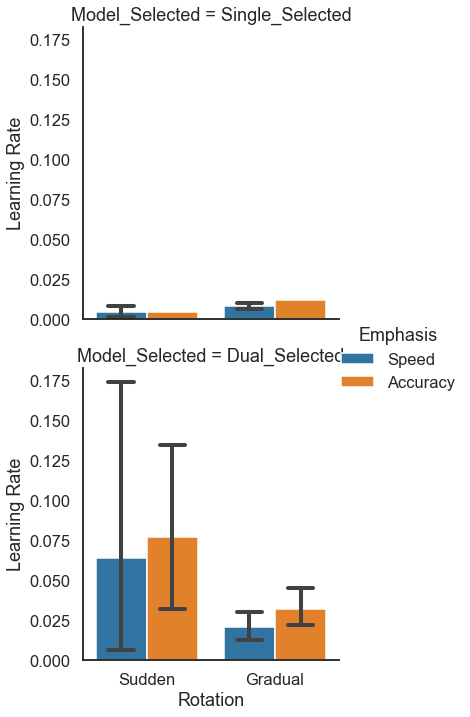

In [37]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2, row = 'Model_Selected')
#plt.title('Best fit by Single state')
#plt.hlines(y = np.max(parameters_means['B'][parameters_means['Model_Selected'] == 'Single_Selected']), 
#           xmin = -0.5, xmax = 2, color = 'black', linestyles='--')
c.set(ylabel = 'Learning Rate')

Text(0.5, 1.0, 'Best fit by Single state')

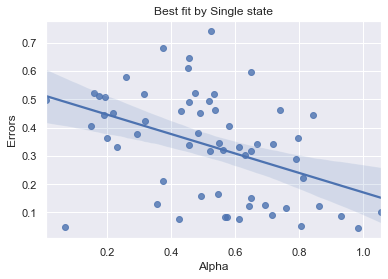

In [68]:
sns.regplot(data = parameters_means,
           x = 'Alpha', y = 'Errors')
plt.title('Best fit by Single state')


In [60]:
num_trials = 704
model_errors_fast = np.zeros((100, 60, num_trials))
model_errors_slow = np.zeros((100, 60, num_trials))

for i in range(100):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:

            model_errors_fast[i][participant]  = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[2]
            model_errors_slow[i][participant]  = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[3]
        
        else:
            model_errors_fast[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[2]
            model_errors_slow[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[3]
        

In [103]:
overtake_index = np.zeros((100, 60))
for i in range(100):
    for participant in range(60):
        overtake_index[i][participant] = np.max((model_errors_fast[i][participant] >= model_errors_slow[i][participant]).nonzero())

In [106]:
overtake_df = pd.DataFrame({'Participant_Id': np.tile(np.arange(60), 100), 
              'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 15*100), 
              'Emphasis': np.tile(['Speed', 'Accuracy'], 30*100), 
              'Overtake_Index': np.ravel(overtake_index)
             })

In [108]:
overtake_means = overtake_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()

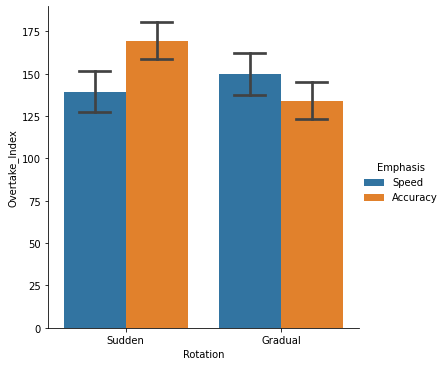

In [113]:
sns.catplot(data = overtake_df,
           x = 'Rotation', y = 'Overtake_Index', hue = 'Emphasis', 
                kind = 'bar', capsize = 0.2)


In [116]:
model = smf.ols('Overtake_Index~Rotation*Emphasis', data = overtake_means[overtake_means['Emphasis'] == 'Accuracy']).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,9432.714720,9432.714720,0.474857,0.496432
Emphasis,0.0,0.000000,NaN,NaN,NaN
Rotation:Emphasis,0.0,0.000000,NaN,NaN,NaN
Residual,28.0,556200.939667,19864.319274,NaN,NaN
